## Setup environment

In [1]:

from monai.utils import first, set_determinism
import torch
import matplotlib.pyplot as plt
import os
from UNet_model import create_unet
import torch.nn as nn
from data_preparation2 import DataHandling 
from datetime import datetime
import json
import numpy as np


In [2]:
data_dir = '/home/shahpouriz/Data/Code_Sama/Practic/ASC-PET-001'
directory = '/home/shahpouriz/Data/Code_Sama/Practic/LOG'
output_dir = '/home/shahpouriz/Data/Code_Sama/Practic/OUT'
log_filename = 'log_2_5_12_13.txt'
log_filepath = directory + '/'+ log_filename

## Set dataset path

In [3]:
# Function to read JSON config file
def read_config(config_path):
    with open(config_path, 'r') as config_file:
        return json.load(config_file)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



print("Starting preparing data ...")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config_path = "/home/shahpouriz/Data/Code_Sama/Practic/training_params.json"
config = read_config(config_path)

data_prep = DataHandling(config)
loaders, val_name, test_name = data_prep.prepare_data(loaders_to_prepare=["val", "test"])
val_loader = loaders.get("val")
test_loader = loaders.get("test")
model = create_unet().to(device)


/home/shahpouriz/Data/new_env/lib64/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Starting preparing data ...
Loading data from: /home/shahpouriz/Data/Code_Sama/ASC-PET-001
Total images loaded: 184


Loading dataset: 100%|██████████| 40/40 [00:08<00:00,  4.64it/s]


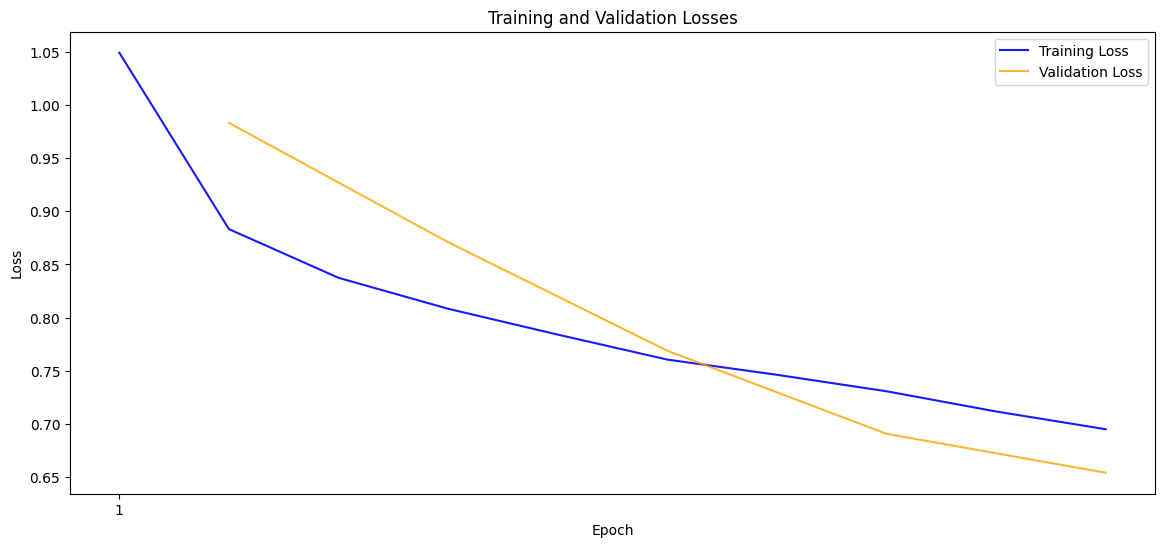

In [4]:

# Function to parse the loss values from the log file
def parse_loss_values(log_filepath):
    train_losses = []
    val_losses = []
    with open(log_filepath, 'r') as file:
        for line in file:
            if 'average loss:' in line:
                loss_value = float(line.split(': ')[-1])
                train_losses.append(loss_value)
            if 'Validation loss:' in line:
                val_loss_value = float(line.split(': ')[-1])
                val_losses.append(val_loss_value)
    return train_losses, val_losses


train_losses, val_losses = parse_loss_values(log_filepath)

max_epochs = len(train_losses)
val_interval = config['val_interval']

# Plotting

plt.figure(figsize=(14, 6))
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', color='blue', alpha=0.9)
plt.plot(range(2, max_epochs + 1, val_interval), val_losses, label='Validation Loss', color='orange', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.xticks(np.arange(1, max_epochs + 1, 20))  # Adjust the x-axis ticks if needed
plt.show()


In [5]:
from utils import find_last_best_model

bestmodel_filename, best_metric, best_epoch = find_last_best_model(log_filepath)
print(f"Last Best Model Saved as: {bestmodel_filename}, Best Metric: {best_metric}, Epoch: {best_epoch}")


Last Best Model Saved as: model_2_5_12_46.pth, Best Metric: 0.6541, Epoch: 10


In [6]:
model_path = os.path.join(directory, model_filename_to_find)
    
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
print("Checkpoint keys:", checkpoint.keys())

# If your model state dict is directly at the root
state_dict_keys = checkpoint.keys()

# If your model state dict is nested under a key, e.g., 'state_dict'
# state_dict_keys = checkpoint['state_dict'].keys()

model_keys = model.state_dict().keys()

print("Keys in checkpoint not in model:", [key for key in state_dict_keys if key not in model_keys])
print("Keys in model not in checkpoint:", [key for key in model_keys if key not in state_dict_keys])

# Check for size mismatches
for key in model_keys:
    if key in checkpoint and checkpoint[key].size() != model.state_dict()[key].size():
        print(f"Size mismatch for {key}: checkpoint {checkpoint[key].size()}, model {model.state_dict()[key].size()}")


Checkpoint keys: odict_keys(['model.0.conv.unit0.conv.weight', 'model.0.conv.unit0.conv.bias', 'model.0.conv.unit0.adn.N.weight', 'model.0.conv.unit0.adn.N.bias', 'model.0.conv.unit0.adn.N.running_mean', 'model.0.conv.unit0.adn.N.running_var', 'model.0.conv.unit0.adn.N.num_batches_tracked', 'model.0.conv.unit1.conv.weight', 'model.0.conv.unit1.conv.bias', 'model.0.conv.unit1.adn.N.weight', 'model.0.conv.unit1.adn.N.bias', 'model.0.conv.unit1.adn.N.running_mean', 'model.0.conv.unit1.adn.N.running_var', 'model.0.conv.unit1.adn.N.num_batches_tracked', 'model.0.residual.weight', 'model.0.residual.bias', 'model.1.submodule.0.conv.unit0.conv.weight', 'model.1.submodule.0.conv.unit0.conv.bias', 'model.1.submodule.0.conv.unit0.adn.N.weight', 'model.1.submodule.0.conv.unit0.adn.N.bias', 'model.1.submodule.0.conv.unit0.adn.N.running_mean', 'model.1.submodule.0.conv.unit0.adn.N.running_var', 'model.1.submodule.0.conv.unit0.adn.N.num_batches_tracked', 'model.1.submodule.0.conv.unit1.conv.weight', 

In [15]:
from utils import find_model_info
def load_model(directory, model_filename):
    model_path = os.path.join(directory, model_filename)
    if os.path.exists(model_path):
        
        # Load the model onto the CPU
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
        print(f"Model file {model_filename} is loaded successfully.")
    else:
        print(f"Model file {model_filename} not found.")


# Usage
# model_filename_to_find = bestmodel_filename
model_filename_to_find = 'model_2_5_12_53.pth'

load_model(directory, model_filename_to_find)

bestmodel_filename, metric, epoch = find_model_info(log_filepath, model_filename_to_find)
print(f"Model has been selected: {bestmodel_filename}, Metric: {metric}, Epoch: {epoch}")

Model file model_2_5_12_20.pth is loaded successfully.
Model has been selected: model_2_5_12_20.pth, Metric: 0.9831, Epoch: 2


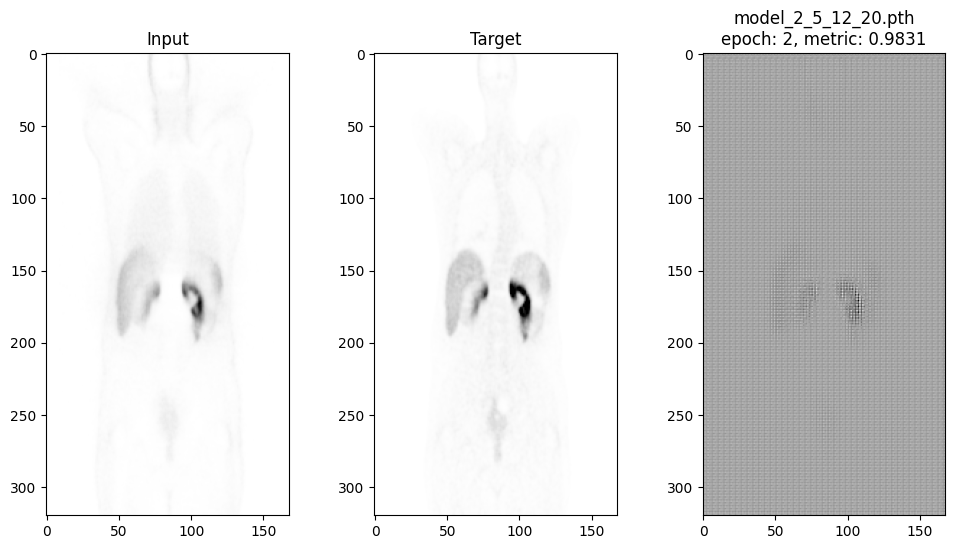

In [19]:
def visualize_results_whole(val_data, model, n, title):
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_data["image"].to(device))

    plt.figure("check", (12, 6))

    plt.subplot(1, 3, 1)
    plt.title(f"Input")
    input_slice = np.rot90(val_data["image"][0, 0, :, n, :])
    plt.imshow(input_slice, cmap="gist_yarg")

    plt.subplot(1, 3, 2)
    plt.title(f"Target")
    target_slice = np.rot90(val_data["target"][0, 0, :, n, :])
    plt.imshow(target_slice, cmap="gist_yarg")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = np.rot90(val_outputs.detach().cpu()[0, 0, :, n, :])
    plt.imshow(output_slice, cmap="gist_yarg")
    
    plt.show()

# Usage
with torch.no_grad():
    for i, val_data in enumerate(test_loader):
        n = 100
        visualize_results_whole(val_data, model, n, f"{model_filename_to_find}\nepoch: {epoch}, metric: {metric}")
        if i == 0:
            break


100%|██████████| 7/7 [00:16<00:00,  2.34s/it]


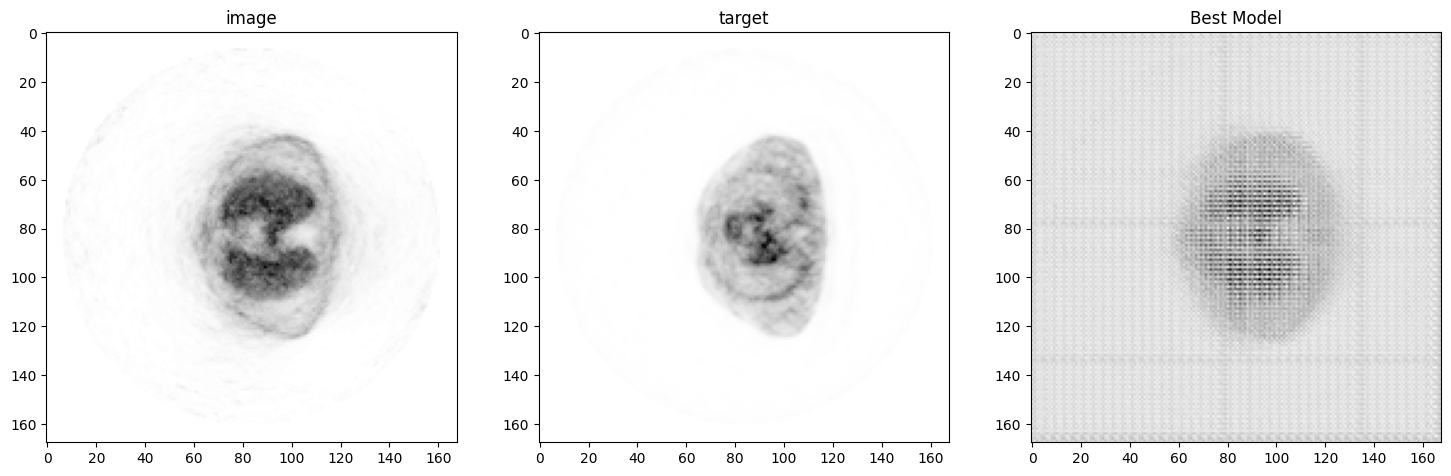

In [9]:
# Loadinf with sliding_window_inference
 
from monai.inferers import sliding_window_inference


        
def visualize_results(val_data, model, n, title):

    val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size,
                          sw_batch_size, model, progress=True, overlap=0.30) # using ov= 0.9 best image ever I have.

    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"image")
    plt.imshow(val_data["image"][0, 0, :, :, n], cmap="gist_yarg")

    plt.subplot(1, 3, 2)
    plt.title(f"target")
    plt.imshow(val_data["target"][0, 0, :, :, n], cmap="gist_yarg")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = val_outputs.detach().cpu()[0, 0, :, :, n]
    plt.imshow(output_slice, cmap="gist_yarg") # "gist_yarg")
    plt.show()


    # Load the best model state for visualization

model.eval()
roi_size = (80, 80, 80)
sw_batch_size = 64 # Increase the overlap by using a higher sw_batch_size
with torch.no_grad():
    for i, val_data in enumerate(val_loader):

        n = 200
        visualize_results(val_data, model, n, f"Best Model")
        if i == 0:
            break




------------------
# Quantification Evaluation

In [10]:
import numpy as np
import torch
from skimage.metrics import structural_similarity as ssim
from math import log10, sqrt

def mean_error(predicted, reference):
    return np.mean(predicted - reference)

def mean_absolute_error(predicted, reference):
    return np.mean(np.abs(predicted - reference))

def relative_error(predicted, reference, epsilon=0.3):
    return np.mean((predicted - reference) / (reference + epsilon)) * 100

def absolute_relative_error(predicted, reference, epsilon=0.3):
    return np.mean(np.abs(predicted - reference) / (reference + epsilon)) * 100

def rmse(predicted, reference):
    return sqrt(np.mean((predicted - reference) ** 2))

def psnr(predicted, reference, peak):
    mse = np.mean((predicted - reference) ** 2)
    return 20 * log10(peak / sqrt(mse))

def calculate_ssim(predicted, reference):
    return ssim(predicted, reference, data_range=reference.max() - reference.min())


In [11]:
# import numpy as np

# def evaluate_metrics(data_loader, model, device):
#     sum_mean_error = sum_mae = sum_re = sum_are = sum_rmse = sum_psnr = sum_ssim = num_patients = 0

#     model.eval()
#     with torch.no_grad():
#         for data in data_loader:
#             inputs, targets = data["image"].to(device), data["target"].to(device)
#             outputs = model(inputs)

#             outputs_np = np.squeeze(outputs.cpu().numpy() * 5, axis=1)
#             targets_np = np.squeeze(targets.cpu().numpy() * 5, axis=1)

#             for output, target in zip(outputs_np, targets_np):
#                 peak = np.max([output.max(), target.max()])
#                 sum_mean_error += mean_error(output, target)
#                 sum_mae += mean_absolute_error(output, target)
#                 sum_re += relative_error(output, target)
#                 sum_are += absolute_relative_error(output, target)
#                 sum_rmse += rmse(output, target)
#                 sum_psnr += psnr(output, target, peak)
#                 sum_ssim += calculate_ssim(output, target)
#                 num_patients += 1

#     metrics = {
#         "mean_ME": sum_mean_error / num_patients,
#         "mean_MAE": sum_mae / num_patients,
#         "mean_RE%": sum_re / num_patients,
#         "mean_ARE%": sum_are / num_patients,
#         "mean_RMSE": sum_rmse / num_patients,
#         "mean_PSNR": sum_psnr / num_patients,
#         "mean_SSIM": sum_ssim / num_patients
#     }

#     return metrics


# val_metrics = evaluate_metrics(val_loader, model, device)
# print("Validation Metrics:")
# for metric, value in val_metrics.items():
#     print(f"{metric}: {value:.2f}")

# test_metrics = evaluate_metrics(test_loader, model, device)
# print("\nTest Metrics:")
# for metric, value in test_metrics.items():
#     print(f"{metric}: {value:.2f}")




In [12]:
def evaluate_metrics(data_loader, model, device):
    metrics = {
        "mean_error": [],
        "mae": [],
        "re": [],
        "are": [],
        "rmse": [],
        "psnr": [],
        "ssim": []
    }

    model.eval()
    with torch.no_grad():
        for data in data_loader:
            inputs, targets = data["image"].to(device), data["target"].to(device)
            outputs = model(inputs)

            outputs_np = np.squeeze(outputs.cpu().numpy() * 5, axis=1)
            targets_np = np.squeeze(targets.cpu().numpy() * 5, axis=1)

            for output, target in zip(outputs_np, targets_np):
                peak = np.max([output.max(), target.max()])
                metrics["mean_error"].append(mean_error(output, target))
                metrics["mae"].append(mean_absolute_error(output, target))
                metrics["re"].append(relative_error(output, target))
                metrics["are"].append(absolute_relative_error(output, target))
                metrics["rmse"].append(rmse(output, target))
                metrics["psnr"].append(psnr(output, target, peak))
                metrics["ssim"].append(calculate_ssim(output, target))

    # Calculate mean and standard deviation for each metric
    metric_means_sds = {
        metric: (np.mean(values), np.std(values)) for metric, values in metrics.items()
    }

    return metric_means_sds
val_metrics = evaluate_metrics(val_loader, model, device)
def print_metrics(metrics, title):
    print(f'\n',title)
    for metric, (mean, sd) in metrics.items():
        print(f"{metric}: {mean:.2f} ± {sd:.2f}")

# val_metrics = evaluate_metrics(val_loader, model, device)
# print_metrics(val_metrics, "Validation Metrics:")

# test_metrics = evaluate_metrics(test_loader, model, device)
# print_metrics(test_metrics, "Test Metrics:")


-------------------------
# Exporting DL-PET output


In [13]:
# import nibabel as nib
# import os
# import numpy as np
# import torch

# def save_nifti(data, filename, affine=np.eye(4)):
#     nifti_img = nib.Nifti1Image(data, affine)
#     nib.save(nifti_img, filename)

# def save_output(test_data, model, output_dir, file_name):
#     model.eval()
#     with torch.no_grad():
#         test_outputs = model(test_data["image"].to(device))

#     # Loop over each item in the batch
#     for i in range(len(test_data["image"])):
#         output_data = test_outputs[i, 0, :, :, :].detach().cpu().numpy()  # Assuming single-channel output
#         output_file_path = os.path.join(output_dir, f"DL_{file_name[i]}")
#         save_nifti(output_data, output_file_path)



# with torch.no_grad():
#     for i, test_data in enumerate(test_loader):
#         # Extract filenames from test_files
#         file_names = [os.path.basename(file_info['image']) for file_info in test_name[i*len(test_data["image"]):(i+1)*len(test_data["image"])]]

#         # Save the output using the modified file names
#         save_output(test_data, model, output_dir, file_names)
#         print(file_names)
#         # if i == 0:
#         #     break

In [14]:
# def save_nifti(data, filename, affine=np.eye(4)):
#     nifti_img = nib.Nifti1Image(data, affine)
#     nib.save(nifti_img, filename)

# def save_output_and_ground_truth(test_data, model, output_dir, file_names):
#     model.eval()
#     with torch.no_grad():
#         test_outputs = model(test_data["image"].to(device))

#     # Loop over each item in the batch
#     for i in range(len(test_data["image"])):

#         # Save ground truth
#         ground_truth_data = test_data["target"][i, 0, :, :, :].detach().cpu().numpy()
#         ground_truth_file_path = os.path.join(output_dir, f"{file_names[i]}")
#         save_nifti(ground_truth_data, ground_truth_file_path)


# with torch.no_grad():
#     for i, test_data in enumerate(test_loader):
#         # Extract filenames from test_files
#         file_names = [os.path.basename(file_info['image']) for file_info in test_name[i*len(test_data["image"]):(i+1)*len(test_data["image"])]]

#         # Save the model output and ground truth using the modified file names
#         save_output_and_ground_truth(test_data, model, output_dir, file_names)
